## 1. Introduction
This project addresses the challenge of planning daily urban maintenance routes with a focus on both operational efficiency and spatial fairness. It is inspired by real-world scenarios such as servicing bike-sharing stations, where tasks of varying priority and complexity must be scheduled under time constraints. The goal is to design a routing approach that not only resolves as many issues as possible within a day but also distributes service attention equitably across different regions of the city.
To meet this objective, a fairness-aware heuristic was developed. This algorithm evaluates each potential task based on its issue severity, required service and travel time, and a fairness weighting that reflects how underserved its area has historically been. The system operates over multiple days and iteratively refines these fairness weights to promote long-term balance. Outputs are generated in Excel format, allowing for detailed performance analysis, including resolution efficiency, fairness by region, and route characteristics.


## 2. Methodology
The problem is modeled as a daily routing challenge with time-limited operations starting and ending at a central hub. Each day, the system must schedule visits to multiple stations, each with a mix of issues categorized into three types, each requiring a specific amount of service time. The goal is to resolve as many issues as possible within the working time while considering both the operational cost and fairness of the selected routes.
A greedy heuristic serves as the core routing mechanism. It evaluates unvisited tasks based on a composite score that reflects issue urgency, service time, travel time, and fairness. This fairness is introduced through distance-based "buckets" that divide the urban space into zones around the hub. Each task is assigned to a bucket based on its distance, and the system tracks unresolved issues in each bucket to detect imbalances in service distribution.
To correct for these imbalances, fairness multipliers are computed at the end of each scheduling cycle. These multipliers are derived from the ratio of unresolved issues per station in each bucket compared to the system-wide average. The routing algorithm is then re-run using these updated weights, influencing task selection in future iterations. This iterative process is repeated multiple times, gradually refining service equity across regions.
The system supports multi-day scheduling. If a day’s tasks cannot be fully completed due to time limits, the unresolved issues are carried over to the following day. Across multiple iterations, the combined effect of route optimization and fairness weighting leads to more balanced and effective long-term service patterns. All outputs, including route plans, service summaries, and fairness evaluations, are stored in structured Excel files for transparency and analysis.


## 3. Routing and Scoring Functions
The key logic for distance calculation, task scoring, and fairness multiplier adjustments is shown below.

### 3.1 Distance Calculation: `manhattan_distance`

This function approximates travel distance between two points using the Manhattan method,
which is better suited for grid-like city layouts than Euclidean distance. It is used in
both travel estimation and route evaluation.


In [ ]:
import math

def manhattan_distance(lat1, lon1, lat2, lon2):
    km_lat = 111.0
    avg_lat = (lat1 + lat2) / 2.0
    km_lon = 111.0 * math.cos(math.radians(avg_lat))
    return abs(lat1 - lat2) * km_lat + abs(lon1 - lon2) * km_lon

### 3.2 Task Prioritization: `compute_candidate_score`

This function assigns a score to each station based on:
- issue severity (weighted sum of unresolved categories),
- time cost (travel + service time), and
- a fairness multiplier based on bucket-level under-service.

Higher scores mean higher priority for inclusion in a route.


In [ ]:
def compute_candidate_score(task, current, hub, speed, repair_times, weights, multipliers, alpha=1.0):
    travel_time = manhattan_distance(current[0], current[1], task['lat'], task['lon']) / speed * 60
    service_time = sum(repair_times[cat] * task[cat] for cat in weights)
    bucket = int(manhattan_distance(hub[0], hub[1], task['lat'], task['lon']))
    coverage = sum(weights[cat] * task[cat] for cat in weights)
    multiplier = multipliers.get(bucket, 1.0)
    score = (coverage / (travel_time + service_time)) * (1 + alpha * multiplier)
    return score, travel_time + service_time

### 3.3 Daily Route Construction: `solve_single_route_heuristic`

This greedy heuristic builds a single daily route under a time constraint.
It selects tasks with the highest adjusted score (from `compute_candidate_score`)
until no more tasks can be feasibly added.

In [ ]:
def solve_single_route_heuristic(tasks, hub_lat, hub_lon,
                                 working_time=480, avg_speed=15,
                                 coef_dict={'cat1': 1, 'cat2': 3, 'cat3': 5},
                                 repair_dict={'cat1': 5, 'cat2': 10, 'cat3': 15},
                                 selected_cats=['cat1', 'cat2', 'cat3'],
                                 fairness_multipliers=None,
                                 alpha=1.0):

    current = (hub_lat, hub_lon)
    remaining_time = working_time
    route = []
    visited_locations = set()
    fairness_multipliers = fairness_multipliers or {}

    while tasks:
        best_task = None
        best_score = -float("inf")
        best_time = 0.0

        for task in tasks:
            if task['location'] in visited_locations:
                continue
            score, cost = compute_candidate_score(task, current, (hub_lat, hub_lon),
                                                  avg_speed, repair_dict, coef_dict,
                                                  fairness_multipliers, alpha)
            return_time = manhattan_distance(task['lat'], task['lon'], hub_lat, hub_lon) / avg_speed * 60
            if cost + return_time > remaining_time:
                continue
            if score > best_score:
                best_task, best_score, best_time = task, score, cost

        if best_task is None:
            break

        route.append(best_task['location'])
        visited_locations.add(best_task['location'])
        remaining_time -= best_time
        current = (best_task['lat'], best_task['lon'])
        tasks = [t for t in tasks if t['location'] not in visited_locations]

    return route

### 3.4 Multi-Day Routing Strategy

This simplified loop runs the daily heuristic over multiple days (iterations),
applying updated fairness multipliers each time. Unresolved tasks from the previous day
are carried over to the next.

In [ ]:
for iteration in range(num_iterations):
    multipliers = compute_weighted_multipliers_from_overall(overall_df)
    route = solve_single_route_heuristic(tasks, hub_lat, hub_lon,
                                         fairness_multipliers=multipliers)
    tasks = [t for t in tasks if t['location'] not in route]

### 3.5 Fairness Adjustment: `compute_weighted_multipliers_from_overall`

This function analyzes unresolved issues per bucket and computes fairness multipliers.
Buckets with higher-than-average IPS are given larger weights in the next routing iteration.


In [ ]:
def compute_weighted_multipliers_from_overall(df_overall):
    unresolved = df_overall['Total Unresolved']
    stations = df_overall['Unique Stations']
    ips = df_overall['Issues per Station']
    total_unresolved = unresolved.sum()
    total_stations = stations.sum()
    target = (total_unresolved / total_stations) if total_stations > 0 else 0
    return {
        b: (ip / target if target > 0 else 0)
        for b, ip in zip(df_overall['Lower Bound'], ips)
    }


## 4. Fairness Evaluation Between Iteration 1 and Iteration 11
Below we compare unresolved issues per station across distance buckets for iteration 1 and iteration 11.

### Table 1: Iteration 1 Results

In [7]:
import pandas as pd
table1 = pd.read_excel('weighted target iteration 1.xlsx', sheet_name='Overall Fairness')
table1 = table1[['Distance Bucket (km)', 'Total Unresolved', 'Unique Stations', 'Issues per Station']]
table1

,Distance Bucket (km),Total Unresolved,Unique Stations,Issues per Station
0,0 - 1,124,24,5.166667
1,1 - 2,358,63,5.682540
2,2 - 3,487,83,5.867470
3,3 - 4,375,79,4.746835
4,4 - 5,418,84,4.976190
5,5 - 6,196,63,3.111111
6,6 - 7,87,36,2.416667
7,7 - 8,56,31,1.806452
8,8 - 9,30,14,2.142857
9,9 - 10,9,7,1.285714


#### Plot: Issues per Station by Bucket (Iteration 1)

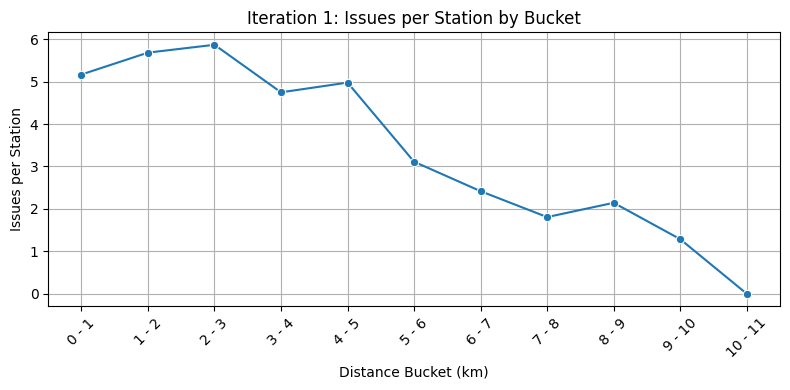

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.lineplot(data=table1, x='Distance Bucket (km)', y='Issues per Station', marker='o')
plt.title('Iteration 1: Issues per Station by Bucket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Table 2: Iteration 11 Results

In [9]:
table2 = pd.read_excel('Weighted target iteration 11.xlsx', sheet_name='Overall Fairness')
table2 = table2[['Distance Bucket (km)', 'Total Unresolved', 'Unique Stations', 'Issues per Station']]
table2

,Distance Bucket (km),Total Unresolved,Unique Stations,Issues per Station
0,0 - 1,123,24,5.125000
1,1 - 2,318,63,5.047619
2,2 - 3,404,83,4.867470
3,3 - 4,358,79,4.531646
4,4 - 5,396,84,4.714286
5,5 - 6,212,63,3.365079
6,6 - 7,94,36,2.611111
7,7 - 8,56,31,1.806452
8,8 - 9,33,14,2.357143
9,9 - 10,10,7,1.428571


#### Plot: Issues per Station by Bucket (Iteration 11)

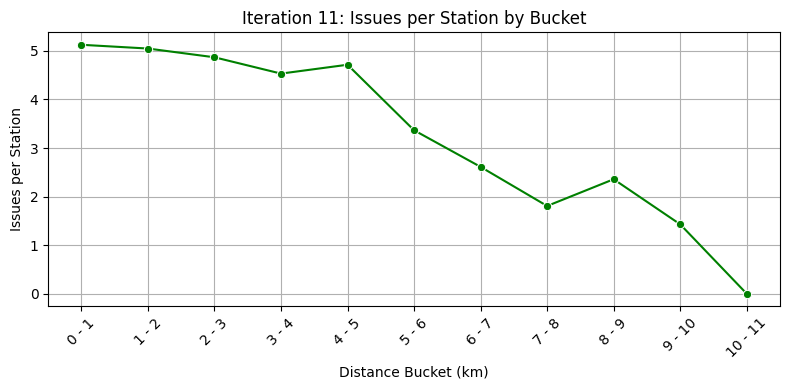

In [13]:
plt.figure(figsize=(8,4))
sns.lineplot(data=table2, x='Distance Bucket (km)', y='Issues per Station', marker='o', color='green')
plt.title('Iteration 11: Issues per Station by Bucket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Comparison Plot: Iteration 1 vs Iteration 11

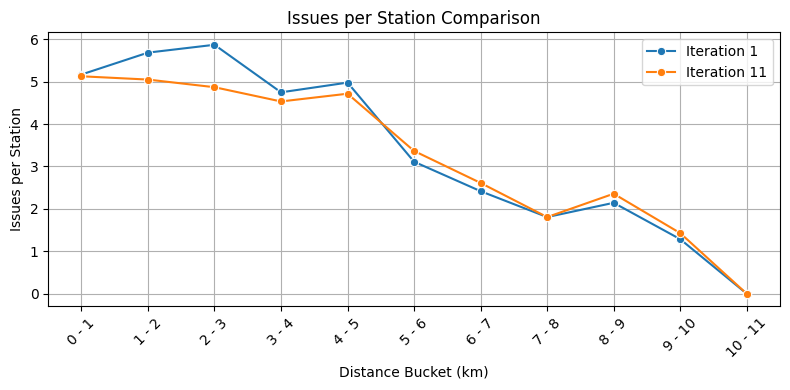

In [14]:
plt.figure(figsize=(8,4))
sns.lineplot(data=table1, x='Distance Bucket (km)', y='Issues per Station', marker='o', label='Iteration 1')
sns.lineplot(data=table2, x='Distance Bucket (km)', y='Issues per Station', marker='o', label='Iteration 11')
plt.title('Issues per Station Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

The IPS values across distance buckets show clear improvement after 11 iterations.
Bucket 3 decreased significantly by approximately 17.0%, and bucket 2 saw an 11.2% reduction,
indicating more equitable issue resolution in these previously high-IPS areas.

Despite these improvements, perfect equality between buckets remains unattainable.
This is due to inherent differences in bucket sizes and issue frequencies—buckets with
higher volumes of issues and more stations naturally exhibit higher IPS values.
These results reflect expected real-world variability and highlight the algorithm’s
ability to reduce imbalance without enforcing artificial uniformity.


## 5. Conclusion
The fairness-aware routing algorithm improves service distribution across geographical regions. Over multiple iterations, it successfully reduces imbalances in unresolved issues per station across distance buckets, demonstrating its effectiveness in balancing efficiency and fairness.